In [1]:
# import necessary libraries
import numpy as np 
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
#import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
from plotnine import *
import io
#to predictive A
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error

/opt/anaconda3/envs/bda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


- 프로펫을 가지고 시계열 예측을 진행해 보자!

- 시계열 데이터를 분석할 수 있는 패키지인 facebook에서 만든 prophet 사용할 것
- prophet도 문제점이 있다. 결과값을 보고 이야기하기

In [5]:
df=pd.read_csv('sales_data.csv',encoding='unicode_escape')

In [7]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


- prophet은 간단하다.
- 특징이 있다. 이건 꼭 지켜야 하는 문법
- 1. 변수가 필요없다. 실제 예측할 값과 시계열 데이터만 있으면 쉽게 예측 가능하다.
- 2. 시계열과 예측값(y)값을 만드는데 특정 컬럼으로 만들어야 한다. 
- 시계열데이터 컬럼 ds 예측값은 y로  

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [10]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [14]:
#간단한 전처리 진행
df_1  = df.copy()

In [20]:
#df_1[df_1.Quantity<0] # 주문데이터의 수량이 -인 경우가 있다. 주문 반품
# 주문반품까지 구체적으로 전처리할 필요는 없고 - 값은 날리고 + 값만 진행하겠습니다.
df_1=df_1[df_1.Quantity>0] #
df_1=df_1[df_1.UnitPrice>0]

In [22]:
df_1['ttp']= df_1['Quantity'] * df_1['UnitPrice']

In [24]:
df_1 # ttp가 실제로 예측할 변수 

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,ttp
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [26]:
df_psp=df_1[['InvoiceDate','ttp']]

In [28]:
df_psp.rename(columns={'InvoiceDate':'ds','ttp':'y'},inplace=True) #prophet 받는 변수명이 ds, y 꼭 

In [29]:
df_psp

,ds,y
0,2010-12-01 08:26:00,15.30
1,2010-12-01 08:26:00,20.34
2,2010-12-01 08:26:00,22.00
3,2010-12-01 08:26:00,20.34
4,2010-12-01 08:26:00,20.34
...,...,...
541904,2011-12-09 12:50:00,10.20
541905,2011-12-09 12:50:00,12.60
541906,2011-12-09 12:50:00,16.60
541907,2011-12-09 12:50:00,16.60


- 일별 주문량으로 정리하여 데이터프레임 만들자

In [31]:
df_psp=df_psp.set_index('ds')

In [33]:
df_f=df_psp.resample('D')['y'].sum()

In [36]:
df_f=df_f.to_frame()

In [37]:
df_f

,y
ds,
2010-12-01,58960.79
2010-12-02,47748.38
2010-12-03,46943.71
2010-12-04,0.00
2010-12-05,31774.95
...,...
2011-12-05,88741.96
2011-12-06,56713.21
2011-12-07,75439.16


<Axes: xlabel='ds'>

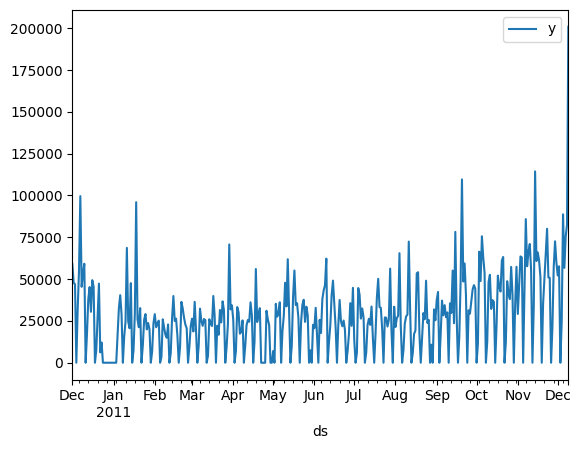

In [38]:
df_f.plot()

- 2010 12월~ 2011 12월까지 
- 점점 우상향하는 경향이 보인다.

- 지가 알아서 다 이런 계절성 등을 잡아준다.
- 알아서 추세, 트렌드를 확인하고 예측해 준다.

In [40]:
df_f.reset_index(inplace=True)#인덱스를 다시 풀어서 두 컬럼으로 만든다. prophet을 돌리기 위해

In [41]:
df_f

,ds,y
0,2010-12-01,58960.79
1,2010-12-02,47748.38
2,2010-12-03,46943.71
3,2010-12-04,0.00
4,2010-12-05,31774.95
...,...,...
369,2011-12-05,88741.96
370,2011-12-06,56713.21
371,2011-12-07,75439.16
372,2011-12-08,82495.00


In [44]:
# train, test로 나누기
# train데이터를 가지고 미래 30일을 예측하여 test 데이터와 비교해서 실제 값이 어떤지 확인한다.

train=df_f[:334]
test = df_f[334:] #시계열 데이터는 shuffle 하지 않는다.

In [45]:
train

,ds,y
0,2010-12-01,58960.79
1,2010-12-02,47748.38
2,2010-12-03,46943.71
3,2010-12-04,0.00
4,2010-12-05,31774.95
...,...,...
329,2011-10-26,38059.43
330,2011-10-27,57291.72
331,2011-10-28,40565.70
332,2011-10-29,0.00


### 필수과제 1
- prophet에 들어가는 하이퍼파라미터 다 정리해 주시고, 실제 값을 넣어서 예측값이 변화하는 것을 확인하기( 코드 & 주석 필수 )

In [47]:
# 프로펫도 하이퍼파라미터가 많습니다.
# holiday 지정 가능하고
# seasonality
# 기타 다양한 하이퍼파라미터가 있다.
# 우리는 거의 기본만 가지고 확인해 볼거고
# 여러분들은 과제로 하이퍼파라미터를 다 찾고 실제로 예측값을 도출해야 한다.

prophet=Prophet(daily_seasonality=True,
       growth='linear')
prophet.fit(train)

22:22:31 - cmdstanpy - INFO - Chain [1] start processing
22:22:31 - cmdstanpy - INFO - Chain [1] done processing


In [63]:
#뒤에 얼마나 예측해서 출력할 것인가?
future=prophet.make_future_dataframe(periods=40) #그 뒤에 얼마나 기간을 예측할 것인가 넣으면 된다. 30일이면 한달, 5면 5일 일개념의 시계열데이터라면
forecast = prophet.predict(future)

In [64]:
ph_yhat=forecast[['ds','yhat']][334:] #실제예측한 값

In [65]:
ph_yhat

,ds,yhat
334,2011-10-31,38113.463656
335,2011-11-01,49040.039309
336,2011-11-02,40398.087118
337,2011-11-03,48061.178221
338,2011-11-04,38490.202436
339,2011-11-05,10090.659207
340,2011-11-06,23858.378036
341,2011-11-07,38684.444505
342,2011-11-08,49611.020157
343,2011-11-09,40969.067967


In [66]:
test

,ds,y
334,2011-10-31,57369.15
335,2011-11-01,29155.15
336,2011-11-02,45888.34
337,2011-11-03,63561.49
338,2011-11-04,62977.36
339,2011-11-05,0.00
340,2011-11-06,42946.34
341,2011-11-07,85881.81
342,2011-11-08,57700.24
343,2011-11-09,66127.57


          ds          yhat    yhat_lower    yhat_upper
0 2010-12-01  29630.181060  12436.477258  47502.293917
1 2010-12-02  37165.707563  19623.071770  53797.378496
2 2010-12-03  27467.167178  10335.340163  44336.689099
3 2010-12-04  -1059.940651 -17668.029850  16475.848644
4 2010-12-05  12580.213579  -3648.338930  28899.809076


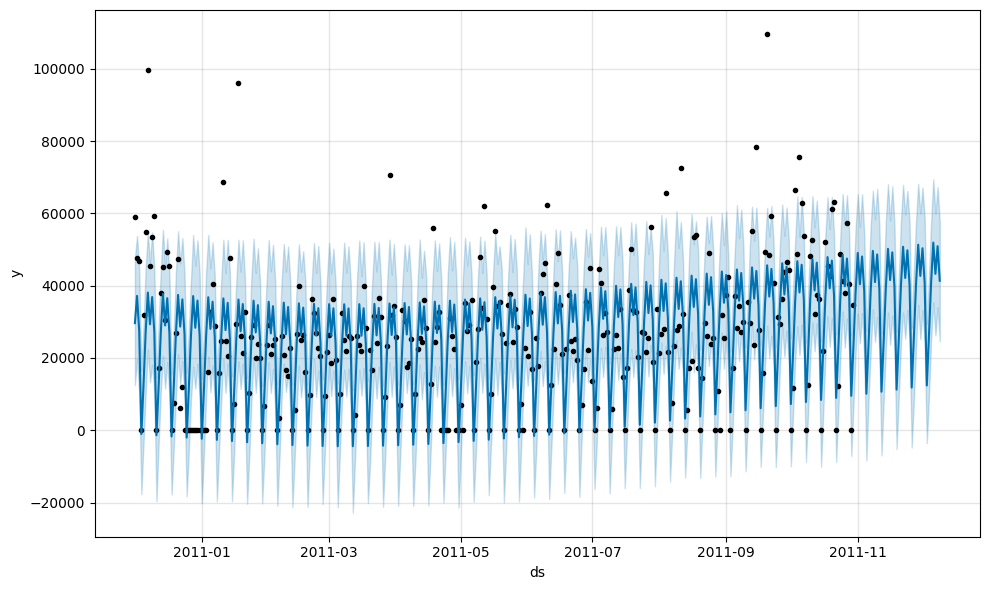

In [67]:
#forecast 시각화
print(forecast[['ds','yhat','yhat_lower','yhat_upper']].head())
#plot을 통한 시각화 
prophet.plot(forecast)
plt.show()

- 시계열 데이터가 기간이 길어지면 평균으로 회귀하는 경우가 이런 케이스

In [59]:
test

,ds,y
334,2011-10-31,57369.15
335,2011-11-01,29155.15
336,2011-11-02,45888.34
337,2011-11-03,63561.49
338,2011-11-04,62977.36
339,2011-11-05,0.00
340,2011-11-06,42946.34
341,2011-11-07,85881.81
342,2011-11-08,57700.24
343,2011-11-09,66127.57


In [60]:
ph_yhat

,ds,yhat
334,2011-10-31,38113.463656
335,2011-11-01,49040.039309
336,2011-11-02,40398.087118
337,2011-11-03,48061.178221
338,2011-11-04,38490.202436
339,2011-11-05,10090.659207
340,2011-11-06,23858.378036
341,2011-11-07,38684.444505
342,2011-11-08,49611.020157
343,2011-11-09,40969.067967


In [68]:
ph_yhat

,ds,yhat
334,2011-10-31,38113.463656
335,2011-11-01,49040.039309
336,2011-11-02,40398.087118
337,2011-11-03,48061.178221
338,2011-11-04,38490.202436
339,2011-11-05,10090.659207
340,2011-11-06,23858.378036
341,2011-11-07,38684.444505
342,2011-11-08,49611.020157
343,2011-11-09,40969.067967


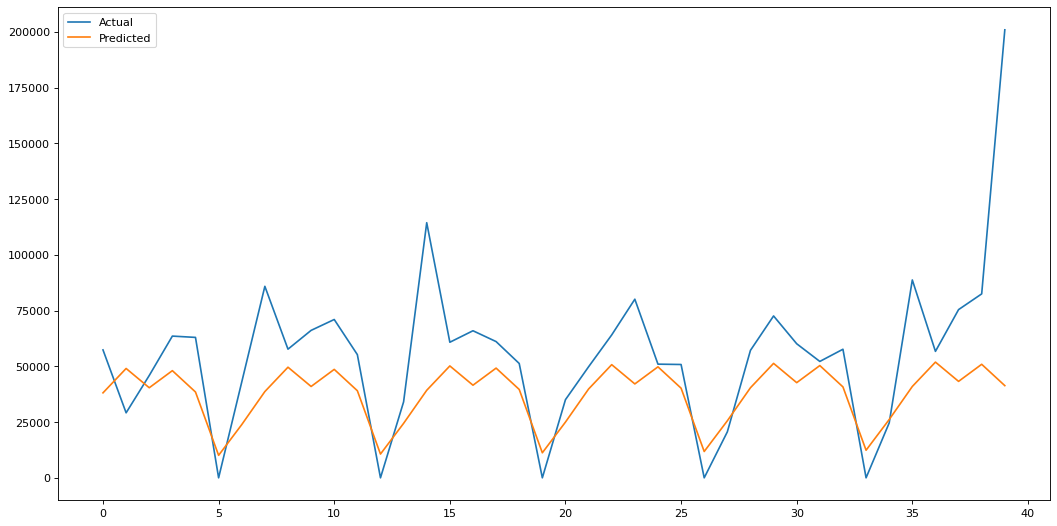

In [69]:
# plot 예측값과 실제 값을 비교해서 트렌드를 보자!
from matplotlib.pyplot import figure
figure(figsize=(16,8), dpi=80)

plt.plot(test['y'].values, label='Actual')
plt.plot(ph_yhat['yhat'].values, label='Predicted')
plt.legend()
plt.show()

- 요일에 대한 트렌드 확인하기

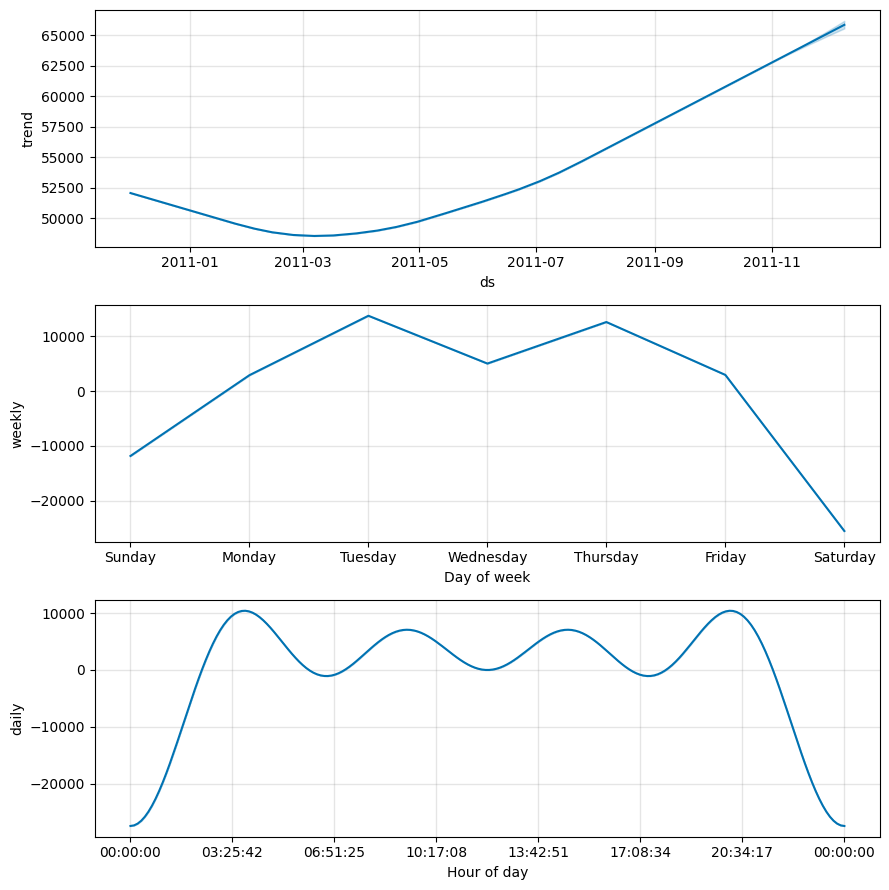

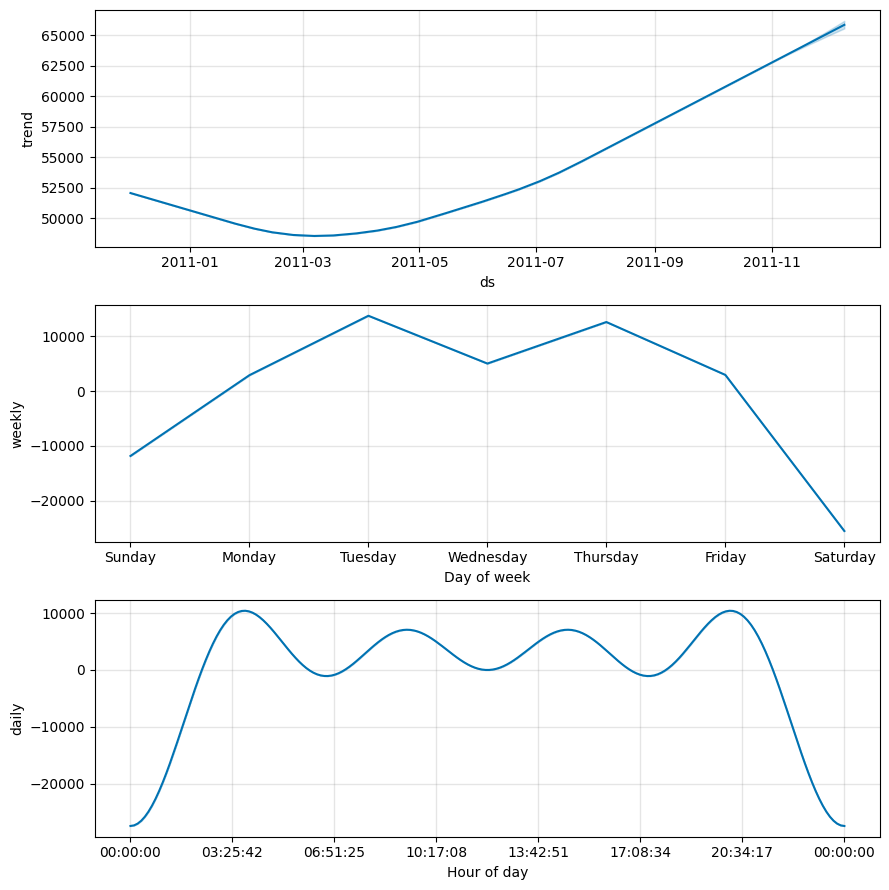

In [70]:
prophet.plot_components(forecast)

### 필수과제2 
- 주가 예측해 보기 !
- 하나의 기업말고 두 개 이상으로 비교해 주세요, ex) 경쟁사, 동종기업, 보완재 등등 다양한 비교가능한 기업들의 주가를 비교 예측해 보는 것
- 실제 금융데이터를 기반으로 주가를 예측하고, 실제 값과 예측한 값이 얼마나 차이나는지를 확인해 보기 
- 투자했을 때 얻을 수 있는 수익까지 간단하게 계산해 보면서 시계열데이터 예측을 진행해 보자!

### 필수과제3
- 과거 주가 데이터를 가지고 시계열 데이터 분석을 해주시는데, 트렌드를 보고 갑자기 상승하거나, 하락하는 경우가 있을 것
- 단순한 재무적 정보가 아니라 비재무적인 정보들도 서칭하셔서 왜 그런식의 트렌드가 반영되었는지 같이 확인하면 좋을 것
- dart 재무적정보 확인 가능, 네이버 금융기사 리서치해도 충분히 다 나온다.


In [73]:
#pip install finance-datareader 패키지 없으면 설치

  Using cached requests_file-1.5.1-py2.py3-none-any.whl (3.7 kB)
Note: you may need to restart the kernel to use updated packages.


In [74]:
import FinanceDataReader as fdr

In [75]:
fdr.StockListing('KRX') #KRX 전체 종목에 대해서 나옴 #해당 기업에 대한 메타데이터
# 실제 주가 가격에대해서도 불러와야 한다 네이버에서 가지고 올 수 있음



,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,70300,1,1500,2.18,69800,70400,69500,19549511,1370668892150,419675713265000,5969782550,STK
1,373220,KR7373220003,LG에너지솔루션,KOSPI,,578000,2,-5000,-0.86,580000,583000,575000,113909,65876235000,135252000000000,234000000,STK
2,000660,KR7000660001,SK하이닉스,KOSPI,,109200,1,5700,5.51,107500,110500,106100,10136706,1096927604183,79497858258000,728002365,STK
3,207940,KR7207940008,삼성바이오로직스,KOSPI,,777000,2,-2000,-0.26,778000,782000,773000,26777,20820335000,55302198000000,71174000,STK
4,051910,KR7051910008,LG화학,KOSPI,,706000,2,-6000,-0.84,708000,716000,697000,133917,94461654000,49838194158000,70592343,STK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2712,245450,KR7245450002,씨앤에스링크,KONEX,일반기업부,1798,2,-1,-0.06,0,0,0,0,0,2840768080,1579960,KNX
2713,000547,KR7000542001,흥국화재2우B,KOSPI,,16960,2,-140,-0.82,16980,17190,16960,278,4732760,2605056000,153600,STK
2714,288490,KR7288490006,나라소프트,KONEX,일반기업부,58,2,-2,-3.33,63,63,55,240726,13846575,2212526000,38147000,KNX
2715,322190,KR7322190000,베른,KONEX,일반기업부,146,1,6,4.29,150,150,140,2012,281696,1303078762,8925197,KNX


- 해당 기업에대해서 실제 주가를 예측해 보자!
- 기업선정은 자율

fdr.DataReader('원하는 기업명')

In [77]:
fdr.DataReader('005930')

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1999-02-10,1653,1675,1604,1634,664282,NaN
1999-02-11,1661,1678,1643,1644,287590,0.006120
1999-02-12,1682,1751,1667,1743,403600,0.060219
1999-02-18,1712,1721,1682,1687,440930,-0.032129
1999-02-19,1663,1663,1602,1653,503847,-0.020154
...,...,...,...,...,...,...
2023-05-22,68400,69000,68000,68500,14470308,0.001462
2023-05-23,68500,68700,68100,68400,8561643,-0.001460
2023-05-24,68100,68700,68000,68500,8192896,0.001462


- 예를 들어 시험 끝나고 6월 20일에 진행하시면 해당 데이터 기준으로 학습할 것 
- 20일 기준 뒤에 10일을 예측한다고 하면
- 20일까지 데이터 기준으로 학습한 값과 실제 10일 뒤에 값을 비교해서 얼마나 상승하는지 하락하는지 등을 비교하면 좋을 것 같다.

- 휴회기간 이후 돌아오는 첫 수업 때 발표진행할 예정
- 랜덤 또는 지원자를 받을 예정 